In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd

sh_or_bat = "sh"
project_folder = r"/Users/fferegrino/Documents/GitHub/information-retrieval/ae2/q2/"
base_folder = r"/Users/fferegrino/Documents/GitHub/information-retrieval/ae2/"
hw_files = r"/Users/fferegrino/Documents/ae1/"
terrier_path =      r"/Users/fferegrino/Documents/terrier-core-4.2"
if os.name == 'nt':
    terrier_path =      r"C:\Users\anton\Terrier"
    project_folder = r"C:\Users\anton\Documents\GitHub\information-retrieval\ae2\q2"
    base_folder = r"C:\Users\anton\Documents\GitHub\information-retrieval\ae2"
    hw_files = r"C:\terrier_data"
    sh_or_bat = "bat"
    
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

logs_folder =       join(project_folder,"logs")
results_folder =    join(project_folder,"results")
features_file =     join(project_folder,"features.txt")
jforest_file =      join(project_folder,"jforests.properties")
terrier_index =     join(hw_files,r"indices/blocks_fields_stemming")
training_topics =   join(hw_files,r"topics/training/topics")
validation_topics = join(hw_files,r"topics/validation/topics")
training_qrels =    join(hw_files,r"topics/training/qrels")
validation_qrels =  join(hw_files,r"topics/validation/qrels")
hp04_topics =       join(hw_files,r"topics/HP04/topics")
hp04_qrels =        join(hw_files,r"topics/HP04/qrels")
feature_files =     join(hw_files,r"features/pagerank.oos.gz")
jar_file =          join(base_folder, r"search-features/target/ircourse-1.0-SNAPSHOT.jar")

terrier = join(terrier_path, "bin", "trec_terrier.%s" % sh_or_bat)
teval = join(terrier_path, "bin", "trec_eval.%s" % sh_or_bat)
anyclass = join(terrier_path, "bin", "anyclass.%s" % sh_or_bat)
letor_tr_file= join(results_folder, "tr.letor")
letor_va_file= join(results_folder, "va.letor")
ensemble_file= join(results_folder, "ensemble.txt")

def write_log(file, content, command=None):
    with open(join(logs_folder, file), "w") as w:
        if command is not None:
            w.write(command + "\n\n")
        for line in content:
            w.write(line + "\n")

## Q2:  
Now, you should implement two additional proximity search features – a proximity search feature allows documents where the query terms occur closely together to be boosted. We require
that you implement two of the functions numbered 1-5 in the following paper: 
 > Ronan Cummins and Colm O'Riordan. 2009. Learning in a pairwise term-term proximity framework for information retrieval. In Proceedings of ACM SIGIR 2009. http://ir.dcs.gla.ac.uk/~ronanc/papers/cumminsSIGIR09.pdf
 
NB: You should calculate your feature by aggregating the function score (mean or min or max, as appropriate) over all pairs of query terms.  

You will implement your new features as two DocumentScoreModifiers (DSM) classes, using the example DSM code provided in the Github repository(https://github.com/cmacdonald/IRcourseHM). 

You can add a DSM as an additional feature by appending its full name to the feature file, e.g.:  

```
DSM:org.myclass.MyProx1DSM  
```

### Q2a:  
Name the two proximity features you have chosen to implement and provide a brief rationale for your choice of these two particular features, especially in terms of how they might affect the performance of the deployed LTR baseline approach of Q1.

#### Features

| Feature       | Class                              |
| ------------- |:----------------------------------:|
| avg_dist      | `uk.ac.gla.dcs.dsms.AvgDistDsm`    |
| diff_avg_pos  | `uk.ac.gla.dcs.dsms.DiffAvgPosDsm` |


In [2]:
# Build package
build_log = !mvn -f search-features/pom.xml clean package 

In [3]:
features = {
    'none': [],
#    'min_dist': ['DSM:uk.ac.gla.dcs.dsms.MinDistDsm'],
#    'avg_min_dist': ['DSM:uk.ac.gla.dcs.dsms.AvgMinDistDsm'],
    'avg_dist': ['DSM:uk.ac.gla.dcs.dsms.AvgDistDsm'],
    'diff_avg_pos': ['DSM:uk.ac.gla.dcs.dsms.DiffAvgPosDsm'],
    'both': ['DSM:uk.ac.gla.dcs.dsms.DiffAvgPosDsm','DSM:uk.ac.gla.dcs.dsms.AvgDistDsm'],
#    'all': ['DSM:uk.ac.gla.dcs.dsms.MinDistDsm', 'DSM:uk.ac.gla.dcs.dsms.AvgMinDistDsm', 'DSM:uk.ac.gla.dcs.dsms.AvgDistDsm', 'DSM:uk.ac.gla.dcs.dsms.DiffAvgPosDsm']
}
template = "WMODEL:SingleFieldModel(BM25,0)\nQI:StaticFeature(OIS,%s)\nDSM:org.terrier.matching.dsms.DFRDependenceScoreModifier" % feature_files

for model in features:
    final = template
    for f in features[model]:
        final += "\n" + f 
    with open(join(project_folder,"features_%s.txt" % model), "w") as w:
        w.write(final)

In [4]:
evals = []
for model in features:
    jforest_statistics = join(results_folder, "jforests-feature-stats.txt")
    if os.path.exists(jforest_statistics):
        os.remove(jforest_statistics)
    
    features_file = join(project_folder,"features_%s.txt" % model)

    tr_letor = "tr_%s.letor" % model
    features_file = join(project_folder,"features_%s.txt" % model)

    letor_tr_file= join(results_folder, tr_letor)
    results_file = join(results_folder,"pl2_tr_ltr_%s.res" % model)
    command="CLASSPATH=%s %s -r -Dtrec.topics=%s " % (jar_file, terrier, training_topics) + \
        "-Dtrec.results.file=%s -Dtrec.model=PL2 -Dterrier.index.path=%s " % (results_file,  terrier_index) + \
        "-Dtrec.matching=FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull " + \
        "-Dtrec.querying.outputformat=Normalised2LETOROutputFormat " + \
        "-Dquerying.postprocesses.order=QueryExpansion,org.terrier.learning.LabelDecorator " + \
        "-Dquerying.postprocesses.controls=labels:org.terrier.learning.LabelDecorator,qe:QueryExpansion " + \
        "-Dquerying.default.controls=labels:on " + \
        "-Dlearning.labels.file=%s " % training_qrels + \
        "-Dtrec.results.file=%s -Dproximity.dependency.type=SD " % letor_tr_file + \
        "-Dfat.featured.scoring.matching.features=FILE -Dfat.featured.scoring.matching.features.file=%s " % features_file 

    run_results = !$command
    write_log("pl2_tr_ltr_%s_querying.log" % model, run_results, command=command)
    print("pl2_tr_ltr_%s_querying.log" % model)

    ###

    va_letor = "va_%s.letor" % model
    letor_va_file= join(results_folder, va_letor)
    results_file = join(results_folder,"pl2_va_ltr_%s.res" % model)
    command="CLASSPATH=%s %s -r -Dtrec.topics=%s " % (jar_file, terrier, validation_topics) + \
        "-Dtrec.results.file=%s -Dtrec.model=PL2 -Dterrier.index.path=%s " % (results_file,  terrier_index) + \
        "-Dtrec.matching=FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull " + \
        "-Dtrec.querying.outputformat=Normalised2LETOROutputFormat " + \
        "-Dquerying.postprocesses.order=QueryExpansion,org.terrier.learning.LabelDecorator " + \
        "-Dquerying.postprocesses.controls=labels:org.terrier.learning.LabelDecorator,qe:QueryExpansion " + \
        "-Dquerying.default.controls=labels:on " + \
        "-Dlearning.labels.file=%s " % validation_qrels + \
        "-Dtrec.results.file=%s -Dproximity.dependency.type=SD " % letor_va_file + \
        "-Dfat.featured.scoring.matching.features=FILE -Dfat.featured.scoring.matching.features.file=%s " % features_file 

    run_results = !$command
    write_log("pl2_va_ltr_%s_querying.log" % model, run_results, command=command)
    print("pl2_va_ltr_%s_querying.log" % model)

    ###

    command="%s edu.uci.jforests.applications.Runner " % anyclass + \
        "--config-file %s " % jforest_file + \
        "--cmd=generate-bin --ranking --folder %s " % results_folder + \
        "--file %s --file %s" %(tr_letor, va_letor)

    run_results = !$command
    write_log("anyclass_run_%s_1.log" % model, run_results, command=command)
    print("anyclass_run_%s_1.log" % model)

    ###

    tr_bin = join(results_folder, "tr_%s.bin" % model)
    va_bin = join(results_folder, "va_%s.bin" % model)
    ensemble_file= join(results_folder, "ensemble_%s.txt" % model)
    command="%s edu.uci.jforests.applications.Runner " % anyclass + \
        "--config-file %s " % jforest_file + \
        "--cmd=train --ranking --folder %s " % results_folder + \
        "--train-file %s --validation-file %s " % (tr_bin, va_bin) + \
        "--output-model %s" % ensemble_file

    run_results = !$command
    write_log("anyclass_run_%s_2.log" % model, run_results, command=command)
    print("anyclass_run_%s_2.log" % model)

    ###

    ltr_test_results_file = join(results_folder,"pl2_te_ltr_%s.res" % model)
    command="CLASSPATH=%s %s -r -Dtrec.model=PL2 -Dtrec.topics=%s " % (jar_file, terrier, hp04_topics) + \
        "-Dtrec.matching=JforestsModelMatching,FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull " + \
        "-Dfat.featured.scoring.matching.features=FILE -Dfat.featured.scoring.matching.features.file=%s " % features_file + \
        "-Dtrec.results.file=%s  -Dterrier.index.path=%s " % (ltr_test_results_file,  terrier_index) + \
        "-Dfat.matching.learned.jforest.model=%s " % ensemble_file + \
        "-Dfat.matching.learned.jforest.statistics=%s " % jforest_statistics + \
        "-Dproximity.dependency.type=SD"

    run_results = !$command
    write_log("pl2_te_ltr_%s_querying.log" % model, run_results, command=command)
    print("pl2_te_ltr_%s_querying.log" % model)

    ###

    eval_file = join(results_folder, "pl2_ltr_%s.eval" % model)
    command = "%s %s %s -q > %s" % (teval, hp04_qrels, ltr_test_results_file, eval_file)
    run_results = !$command
    write_log("pl2_ltr_%s_eval.log" % model, run_results, command=command)
    print("pl2_ltr_%s_eval.log" % model)
    
    evals.append(eval_file)

pl2_tr_ltr_none_querying.log
pl2_va_ltr_none_querying.log
anyclass_run_none_1.log
anyclass_run_none_2.log
pl2_te_ltr_none_querying.log
pl2_ltr_none_eval.log
pl2_tr_ltr_avg_dist_querying.log
pl2_va_ltr_avg_dist_querying.log
anyclass_run_avg_dist_1.log
anyclass_run_avg_dist_2.log
pl2_te_ltr_avg_dist_querying.log
pl2_ltr_avg_dist_eval.log
pl2_tr_ltr_diff_avg_pos_querying.log
pl2_va_ltr_diff_avg_pos_querying.log
anyclass_run_diff_avg_pos_1.log
anyclass_run_diff_avg_pos_2.log
pl2_te_ltr_diff_avg_pos_querying.log
pl2_ltr_diff_avg_pos_eval.log
pl2_tr_ltr_both_querying.log
pl2_va_ltr_both_querying.log
anyclass_run_both_1.log
anyclass_run_both_2.log
pl2_te_ltr_both_querying.log
pl2_ltr_both_eval.log


In [123]:
def read_eval(eval_file, skip_first=True):
    data = pd.read_table(eval_file,
                         sep='\t',
                         header=None,
                         skiprows=[0, 1] if skip_first else None,
                         names=['measure', 'query', 'value'])
    # Split frames:
    data.dropna(inplace=True)
    data['measure'] = data['measure'].str.strip()
    
    per_query = data[data['query'] != 'all'].pivot(index='query', columns='measure', values='value')
    per_query.index = per_query.index.astype(int)
    per_query.sort_index(inplace=True)
    
    totals = data[data['query'] == 'all'].pivot(index='query', columns='measure', values='value')
    
    return totals, per_query


pl2_ltr_none_total, pl2_ltr_none_pq = read_eval('/Users/fferegrino/Documents/GitHub/information-retrieval/ae2/q2/results/pl2_ltr_none.eval')
pl2_ltr_avg_dist_total, pl2_ltr_avg_dist_pq = read_eval('/Users/fferegrino/Documents/GitHub/information-retrieval/ae2/q2/results/pl2_ltr_avg_dist.eval')
pl2_ltr_diff_avg_pos_total, pl2_ltr_diff_avg_pos_pq = read_eval('/Users/fferegrino/Documents/GitHub/information-retrieval/ae2/q2/results/pl2_ltr_diff_avg_pos.eval')
pl2_ltr_both_total, pl2_ltr_both_pq = read_eval('/Users/fferegrino/Documents/GitHub/information-retrieval/ae2/q2/results/pl2_ltr_both.eval')

print(pl2_ltr_both_pq)

measure    P_10   P_100  P_1000    P_15    P_20   P_200    P_30     P_5  \
query                                                                     
6        0.1000  0.0100  0.0010  0.0667  0.0500  0.0050  0.0333  0.0000   
7        0.1000  0.0100  0.0010  0.0667  0.0500  0.0050  0.0333  0.0000   
9        0.2000  0.0200  0.0020  0.1333  0.1000  0.0100  0.0667  0.0000   
17       0.1000  0.0100  0.0010  0.0667  0.0500  0.0050  0.0333  0.2000   
29       0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
32       0.1000  0.0100  0.0010  0.0667  0.0500  0.0050  0.0333  0.2000   
35       0.1000  0.0100  0.0010  0.0667  0.0500  0.0050  0.0333  0.2000   
46       0.0000  0.0100  0.0010  0.0000  0.0000  0.0050  0.0000  0.0000   
49       0.1000  0.0100  0.0010  0.0667  0.0500  0.0050  0.0333  0.2000   
51       0.1000  0.0100  0.0010  0.0667  0.0500  0.0050  0.0333  0.2000   
52       0.4000  0.0400  0.0040  0.2667  0.2000  0.0200  0.1333  0.8000   
54       0.1000  0.0100  

In [124]:
print("MAP")
print("Baseline:")
print(",".join([m[0] for m in pl2_ltr_none_pq[["map"]].sort_index().values]),"\n")
print()
print("avg_dist:")
print(",".join([m[0] for m in pl2_ltr_avg_dist_pq[["map"]].sort_index().values]))
print()
print("diff_avg_pos:")
print(",".join([m[0] for m in pl2_ltr_diff_avg_pos_pq[["map"]].sort_index().values]))
print()
print("avg_dist + diff_avg_pos:")
print(",".join([m[0] for m in pl2_ltr_both_pq[["map"]].sort_index().values]))

MAP
Baseline:
0.2000,0.1250,0.1288,1.0000,0.0000,0.3333,0.1429,0.0132,1.0000,0.3333,1.0000,0.2000,1.0000,1.0000,1.0000,0.3667,0.3333,1.0000,1.0000,0.5000,0.5000,0.5000,0.5000,1.0000,0.0244,0.1667,1.0000,0.0833,1.0000,0.0130,0.0526,1.0000,1.0000,0.1111,0.0418,0.1429,0.5000,0.0769,0.5000,1.0000,1.0000,1.0000,0.5000,0.1429,0.0000,0.0000,0.2000,0.5000,1.0000,1.0000,0.2000,0.2500,0.0079,1.0000,0.0357,1.0000,0.0000,0.0000,0.5000,1.0000,0.0667,0.1111,0.5000,0.0196,0.0256,0.0345,0.1667,1.0000,0.5000,1.0000,0.0238,1.0000,0.3333,1.0000,0.1667 


avg_dist:
1.0000,0.1111,0.1288,1.0000,0.0000,0.5000,0.5000,0.0182,1.0000,0.3333,1.0000,0.3333,1.0000,1.0000,0.5000,0.2262,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.5000,1.0000,0.0385,0.2500,0.5000,0.1429,1.0000,0.0217,0.0256,1.0000,1.0000,0.0769,0.0871,0.1111,1.0000,0.0909,1.0000,1.0000,0.5000,0.1000,0.3333,0.1111,0.0000,0.0000,0.5000,0.5000,1.0000,1.0000,0.1667,0.0417,0.0092,1.0000,0.2500,1.0000,0.0000,0.0000,0.5000,1.0000,0.0500,0.0714,0.5000,0.0320,

In [125]:
markers = [",", ".", "o", "v"]
linestyles = ['-', '--', '-.', ':']

def plot_not_broken(frames, labels, topic, bottom, top, figsize=(15,7.5)):
    plt.style.use('seaborn-poster')
    f = plt.figure(figsize=figsize)
    for i in range(len(frames)):
        qq = get_recalls(frames[i])
        plt.plot(qq.recall, qq.value, marker=markers[i], linestyle=linestyles[i], label=labels[i])
        
    plt.ylim(bottom, top)  # outliers only
    
    plt.suptitle('Precission-Recall - %s' % topic, size='x-large')
    plt.ylabel('Precission', size='large')
    plt.xlabel('Recall', size='large')
    plt.xticks([ ii for ii in np.linspace(0,1,11)])
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), fontsize='large')

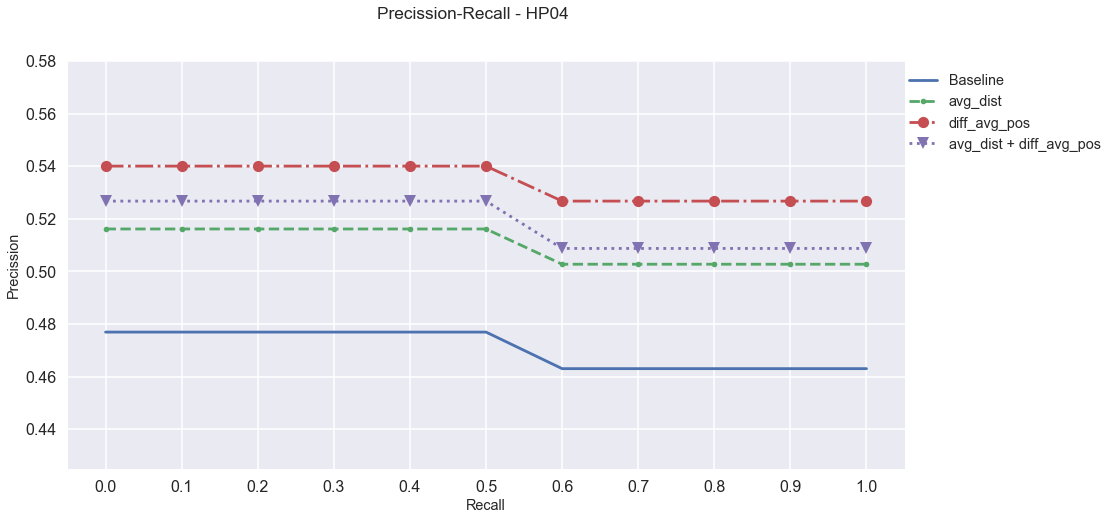

In [173]:
import matplotlib.pyplot as plt

plot_not_broken(
    [pl2_ltr_none_total, pl2_ltr_avg_dist_total, pl2_ltr_diff_avg_pos_total, pl2_ltr_both_total],
    ['Baseline', 'avg_dist', 'diff_avg_pos', 'avg_dist + diff_avg_pos'],
    'HP04',
    0.425, 0.58
)

plt.show()

In [190]:
import seaborn as sns
pl2_ltr_none_pq['type'] = 'Baseline'
pl2_ltr_avg_dist_pq['type'] = 'avg_dist'
pl2_ltr_diff_avg_pos_pq['type'] = 'diff_avg_pos'
pl2_ltr_both_pq['type'] = 'diff_avg_pos + avg_dist'

joint = pd.concat([
    pl2_ltr_none_pq, 
    pl2_ltr_avg_dist_pq, 
    pl2_ltr_diff_avg_pos_pq, 
    pl2_ltr_both_pq
]).reset_index()

joint['query'] = joint['query'].astype(int)
joint['map'] = joint['map'].astype(float)
joint[['query', 'map']].dtypes
a = pl2_ltr_none_pq.reset_index()

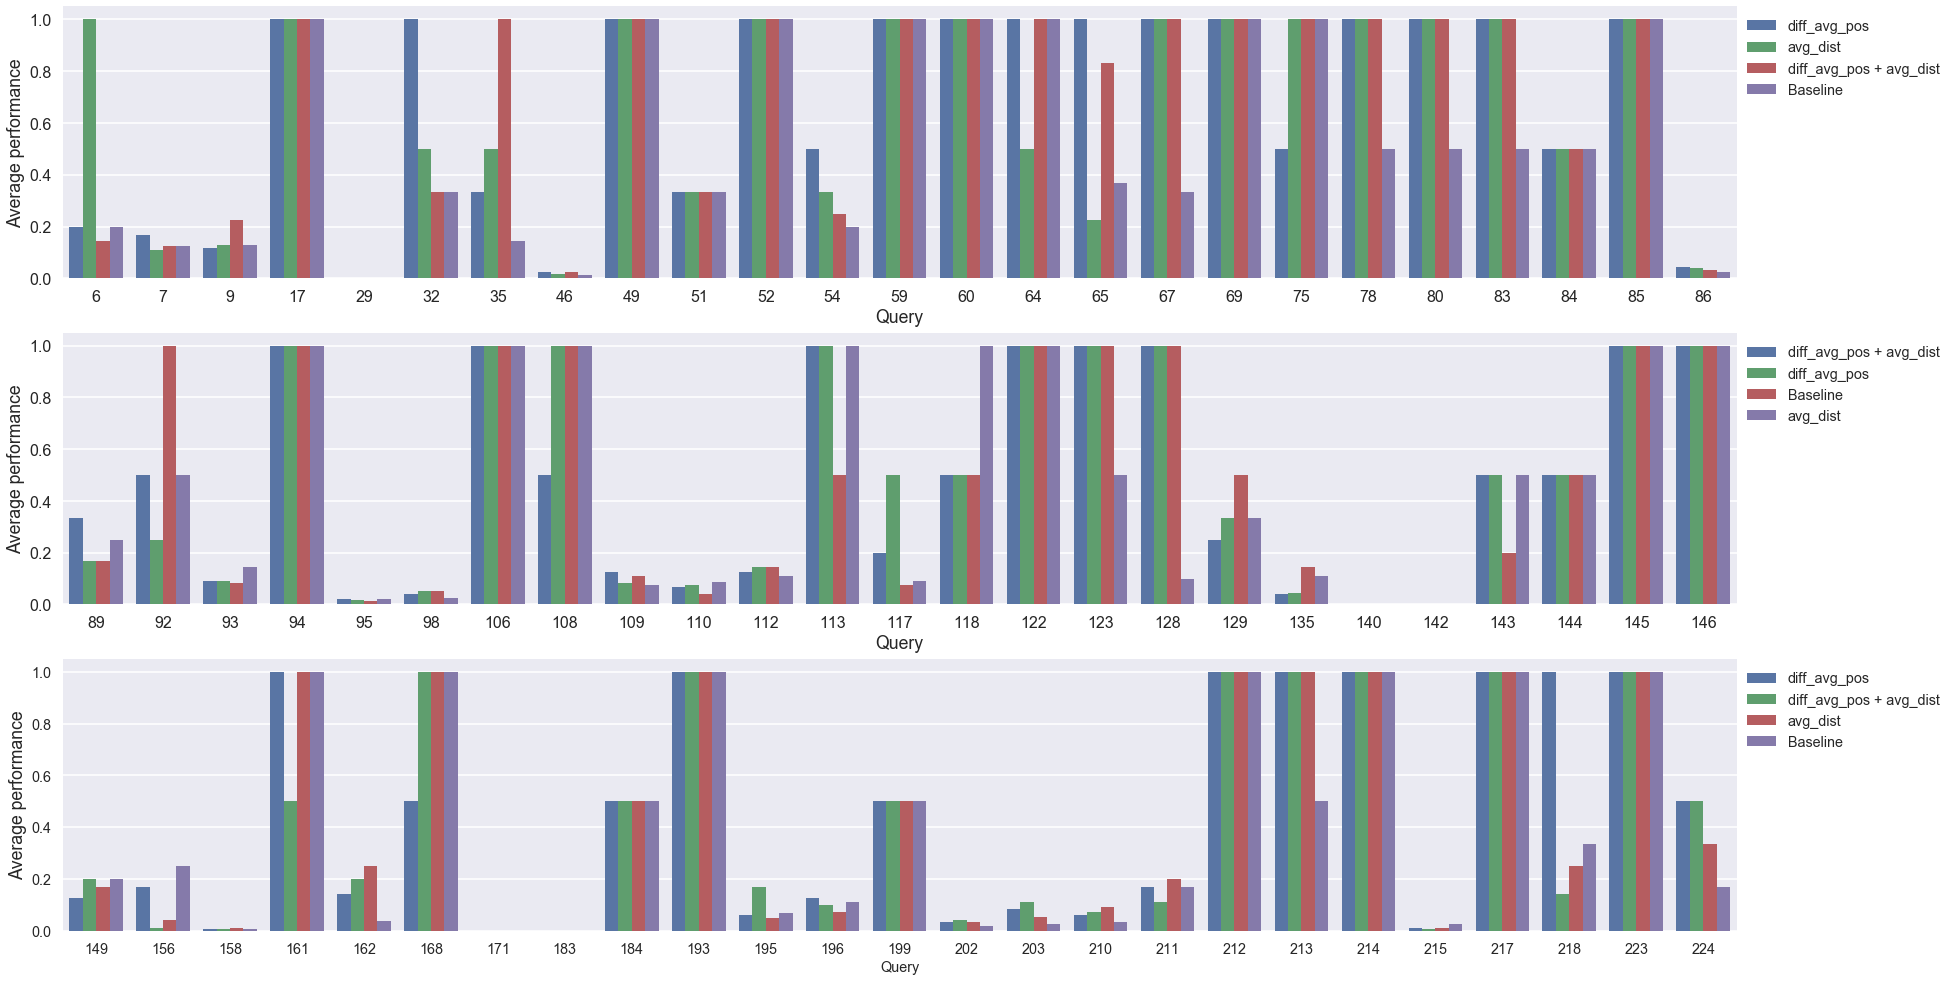

In [226]:
midquery = len(a.index) // 3
s1 = a.iloc[midquery]['query']
s2 = a.iloc[midquery*2]['query']
fig = plt.figure(figsize=(30,17))
plt.title("Performance for topics in HP04", size='x-large')

ax = plt.subplot(311)
sns.barplot(x='query', y='map', hue='type',data=joint[joint['query'] < s1], ax= ax)
ax.set_ylabel("Average performance")
ax.set_xlabel("Query")
ax.legend(loc='upper right', bbox_to_anchor=(1.129, 1.0), fontsize='large')

ax = plt.subplot(312)
sns.barplot(x='query', y='map', hue='type',data=joint[((s1 <= joint['query']) & (joint['query'] < s2))], ax= ax)
ax.set_ylabel("Average performance")
ax.set_xlabel("Query")
ax.legend(loc='upper right', bbox_to_anchor=(1.129, 1.0), fontsize='large')

ax = plt.subplot(313)
sns.barplot(x='query', y='map', hue='type',data=joint[s2 <= joint['query']], ax= ax)
ax.set_ylabel("Average performance")
ax.set_xlabel("Query")
ax.legend(loc='upper right', bbox_to_anchor=(1.129, 1.0), fontsize='large')



plt.yticks(size='large')
plt.xticks(size='large')
plt.xlabel("Query", size='large')

plt.show();


In [236]:
all_q = pd.DataFrame({
'baseline': pl2_ltr_none_pq['map'], 
'avg_dist': pl2_ltr_avg_dist_pq['map'], 
'diff_avg_pos':pl2_ltr_diff_avg_pos_pq['map'], 
'both':pl2_ltr_both_pq['map']
})[['baseline', 'avg_dist', 'diff_avg_pos', 'both']]

all_q['baseline'] = table['baseline'].astype(float)
all_q['avg_dist'] = table['avg_dist'].astype(float)
all_q['diff_avg_pos'] = table['diff_avg_pos'].astype(float)
all_q['both'] = table['both'].astype(float)

all_q['avg_dist_diff'] = table['baseline'] - table['avg_dist']
all_q['diff_avg_pos_diff'] = table['baseline'] - table['diff_avg_pos']
all_q['both_diff'] = table['baseline'] - table['both']

all_q.head()

,baseline,avg_dist,diff_avg_pos,both,avg_dist_diff,diff_avg_pos_diff,both_diff
query,,,,,,,
6,0.2000,1.0000,0.2000,0.1429,-0.8000,0.0000,0.0571
7,0.1250,0.1111,0.1667,0.1250,0.0139,-0.0417,0.0000
9,0.1288,0.1288,0.1186,0.2262,0.0000,0.0102,-0.0974
17,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000
29,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [251]:
summary = pd.DataFrame([
[len(all_q[all_q['avg_dist_diff']  < 0]), 
 len(all_q[all_q['avg_dist_diff']  == 0]), 
 len(all_q[0 < all_q['avg_dist_diff']])],
    
[len(all_q[all_q['diff_avg_pos_diff']  < 0]), 
 len(all_q[all_q['diff_avg_pos_diff']  == 0]), 
 len(all_q[0 < all_q['diff_avg_pos_diff']])],
    
[len(all_q[all_q['both_diff']  < 0]), 
 len(all_q[all_q['both_diff']  == 0]), 
 len(all_q[0 < all_q['both_diff']])],
], columns=['Improved','Unaffected','Degraded'])
summary.index = ['avg_dist', 'diff_avg_pos', 'avg_dist + diff_avg_pos' ]
summary

,Improved,Unaffected,Degraded
avg_dist,26,32,17
diff_avg_pos,25,37,13
avg_dist + diff_avg_pos,25,36,14


In [253]:
# negative diff means improvement
all_q.describe()

,baseline,avg_dist,diff_avg_pos,both,avg_dist_diff,diff_avg_pos_diff,both_diff
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,0.468983,0.507964,0.532696,0.516741,-0.038981,-0.063713,-0.047759
std,0.407429,0.419605,0.421453,0.418691,0.246342,0.241594,0.223724
min,0.000000,0.000000,0.000000,0.000000,-0.800000,-0.666700,-0.857100
25%,0.097200,0.090900,0.104750,0.111100,-0.030150,-0.020800,-0.023000
50%,0.333300,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.900000,0.750000,0.500000


In [288]:
def read_topics(file):
    queries = {}
    lines = None
    with open(file, "r") as topic_file:
        lines = topic_file.readlines()
    i = 0
    number = -1
    query = None
    for line in lines:
        line = line.strip()
        if line == '':
            continue
        i = (i + 1) % 4
        if i == 2 and number == -1:  # number
            number = int(line[line.index(':') + 1:].strip())
        elif i == 3 and number != -1:
            queries[number] = line[line.index('>') + 1:].strip()
            number = -1
    return queries

qq = read_topics("/Users/fferegrino/Documents/ae1/topics/HP04/topics")


def show_impdeg(columns):
    threshold = .5
    for c in columns:
        improved = all_q[all_q[c] < -threshold]
        degraded = all_q[all_q[c] >  threshold]

        print(c, "improved:")
        print("\n".join(["%d %s" % (q, qq[q]) for q in improved.index]))
        print()
        print(c, "degraded:")
        print("\n".join(["%d %s" % (q, qq[q]) for q in degraded.index]))
        print();print();
        
show_impdeg(['avg_dist_diff', 'diff_avg_pos_diff', 'both_diff'])

avg_dist_diff improved:
6 Philadelphia streets
67 State local gateway

avg_dist_diff degraded:
128 Planetary balloon program


diff_avg_pos_diff improved:
32 A history of American agriculture
65 California art council
67 State local gateway
218 MedWatch

diff_avg_pos_diff degraded:
92 DOE illness compensation


both_diff improved:
35 Religious Freedom amendment
67 State local gateway

both_diff degraded:



